##Customer Churn Prediction with Business-Oriented Evaluation

#### Problem: Predict customer churn for a subscription business and prioritize retention actions under budget constraints.
#### Approach: Trained a LightGBM model with class-imbalance handling, selected an operational threshold using recall-focused criteria, evaluated business impact with cost-based analysis, and explained predictions using SHAP.


###Setup / Imports

In [2]:
import kagglehub
path = kagglehub.dataset_download("miadul/customer-churn-prediction-business-dataset")
print("Path to dataset files:", path)

100%|██████████| 508k/508k [00:00<00:00, 12.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/miadul/customer-churn-prediction-business-dataset/versions/1


###Imports

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix
import shap
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
os.listdir(path)

['customer_churn_business_dataset.csv']

In [5]:
csv_path = os.path.join(path, "customer_churn_business_dataset.csv")
df = pd.read_csv(csv_path)

print(df.shape)
df.head()

(10000, 32)


,customer_id,gender,age,country,city,customer_segment,tenure_months,signup_channel,contract_type,monthly_logins,...,avg_resolution_time,complaint_type,csat_score,escalations,email_open_rate,marketing_click_rate,nps_score,survey_response,referral_count,churn
0,CUST_00001,Male,68,Bangladesh,London,SME,22,Web,Monthly,26,...,13.354360,Service,4.0,0,0.71,0.40,27,Satisfied,1,0
1,CUST_00002,Female,57,Canada,Sydney,Individual,9,Mobile,Monthly,7,...,25.140088,Billing,2.0,0,0.78,0.33,-19,Neutral,2,1
2,CUST_00003,Male,24,Germany,New York,SME,58,Web,Yearly,19,...,27.572928,Service,3.0,0,0.35,0.49,80,Neutral,1,0
3,CUST_00004,Male,49,Australia,Dhaka,Individual,19,Mobile,Yearly,34,...,26.420822,Technical,5.0,1,0.83,0.15,100,Neutral,0,0
4,CUST_00005,Male,65,Bangladesh,Delhi,Individual,52,Web,Monthly,20,...,26.674579,Technical,4.0,0,0.65,0.44,21,Unsatisfied,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             10000 non-null  object 
 1   gender                  10000 non-null  object 
 2   age                     10000 non-null  int64  
 3   country                 10000 non-null  object 
 4   city                    10000 non-null  object 
 5   customer_segment        10000 non-null  object 
 6   tenure_months           10000 non-null  int64  
 7   signup_channel          10000 non-null  object 
 8   contract_type           10000 non-null  object 
 9   monthly_logins          10000 non-null  int64  
 10  weekly_active_days      10000 non-null  int64  
 11  avg_session_time        10000 non-null  float64
 12  features_used           10000 non-null  int64  
 13  usage_growth_rate       10000 non-null  float64
 14  last_login_days_ago     10000 non-null 

In [7]:
# Target distribution
df["churn"].value_counts(normalize=True)

,proportion
churn,
0,0.8979
1,0.1021


###Data Cleaning

In [8]:
# Missing values
df.isna().sum().sort_values(ascending=False).head(10)

,0
complaint_type,2045
customer_id,0
age,0
gender,0
city,0
customer_segment,0
tenure_months,0
country,0
contract_type,0
monthly_logins,0


In [9]:
# Fill missing complaint type as "None"
df["complaint_type"] = df["complaint_type"].fillna("None")

# Drop duplicates just in case
df = df.drop_duplicates()

# Re-check
df.isna().sum().head()

,0
customer_id,0
gender,0
age,0
country,0
city,0


###EDA

####Target Distribution

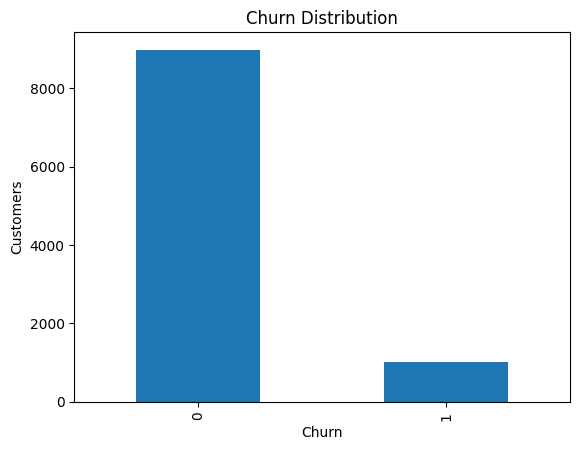

In [41]:
df["churn"].value_counts().plot(kind="bar")
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Customers")
plt.show()

####Tenure and Churn

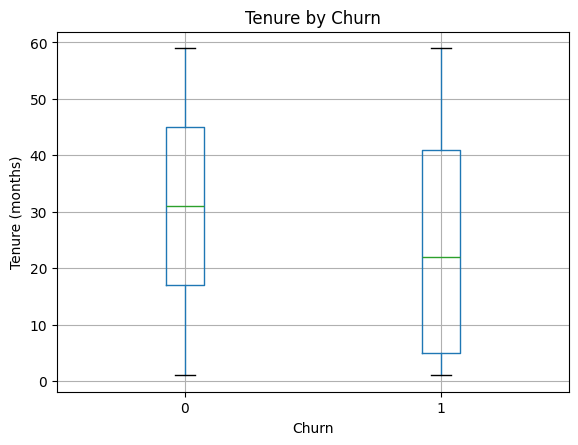

In [11]:
df.boxplot(column="tenure_months", by="churn")
plt.title("Tenure by Churn")
plt.suptitle("")
plt.xlabel("Churn")
plt.ylabel("Tenure (months)")
plt.show()

Customers who churn tend to have shorter tenure compared to retained customers.
This suggests that churn is more likely to occur early in the customer lifecycle, potentially due to onboarding issues or unmet expectations.

####Engagement Behavior

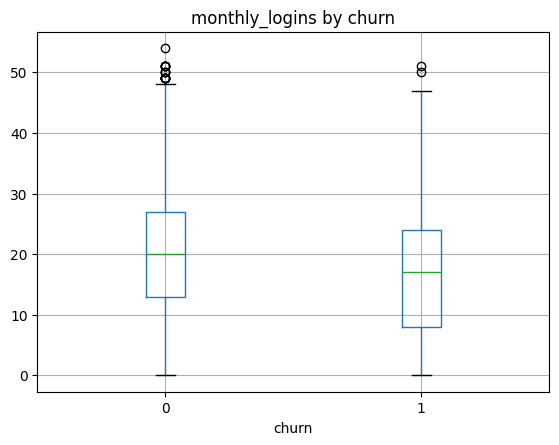

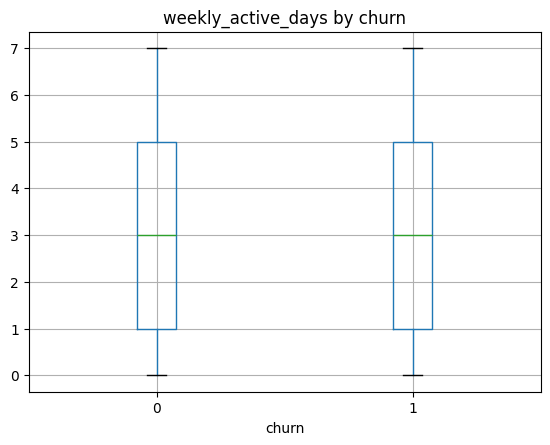

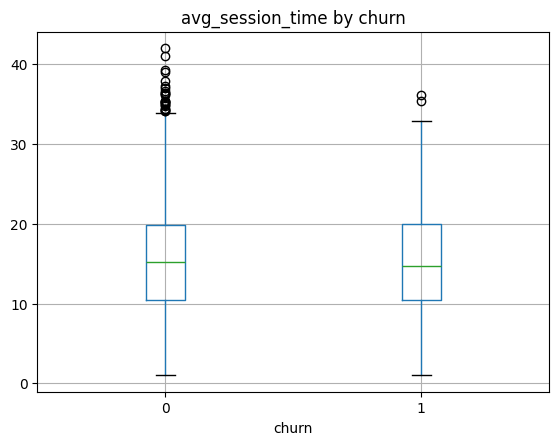

In [12]:
for col in ["monthly_logins", "weekly_active_days", "avg_session_time"]:
    df.boxplot(column=col, by="churn")
    plt.title(f"{col} by churn")
    plt.suptitle("")
    plt.show()

Engagement-related features such as:

- monthly logins

- weekly active days

- average session time

show lower median values for churned customers.
This indicates that reduced product engagement is a strong early signal of churn risk.

####Payment Behavior

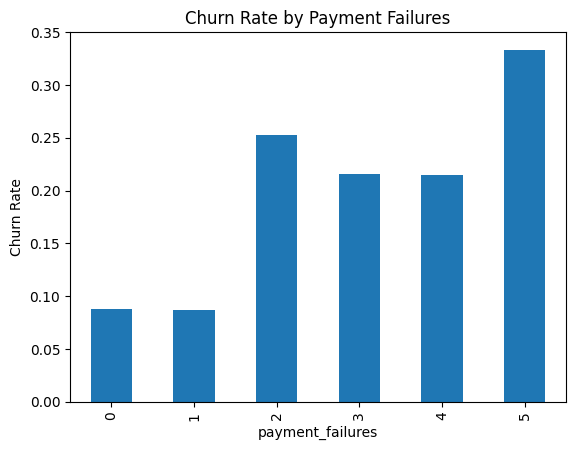

In [13]:
df.groupby("payment_failures")["churn"].mean().plot(kind="bar")
plt.title("Churn Rate by Payment Failures")
plt.ylabel("Churn Rate")
plt.show()

Churn rate increases noticeably as the number of payment failures rises.
This pattern suggests that billing issues or payment friction play an important role in customer churn and represent a clear intervention opportunity.

####Customer Satisfaction

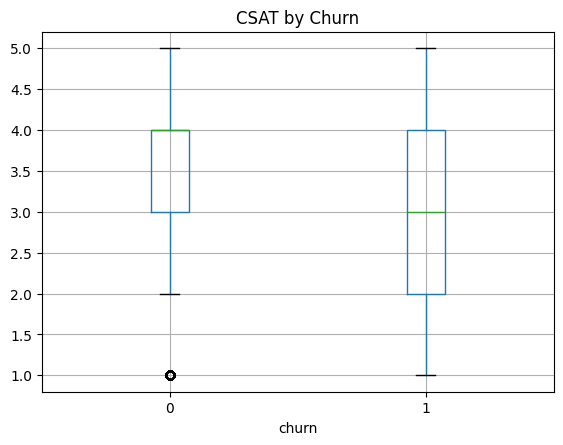

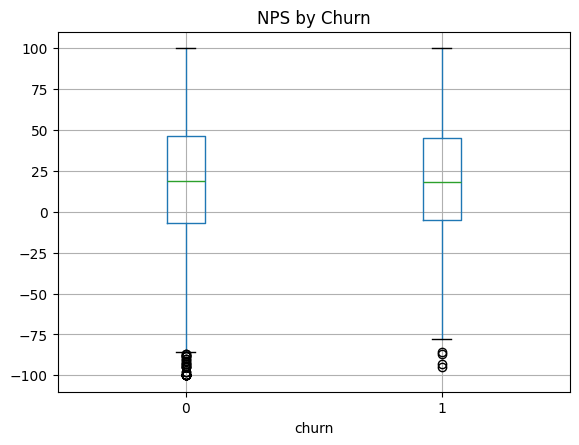

In [14]:
df.boxplot(column="csat_score", by="churn")
plt.title("CSAT by Churn")
plt.suptitle("")
plt.show()

df.boxplot(column="nps_score", by="churn")
plt.title("NPS by Churn")
plt.suptitle("")
plt.show()

Customer satisfaction metrics show strong separation between churned and retained users:

- Customers with lower CSAT scores are more likely to churn

- Lower NPS scores are associated with higher churn probability

This highlights the importance of service quality and customer experience in retention.

###Train/Test Split

In [15]:
TARGET = "churn"
ID_COL = "customer_id"

X = df.drop(columns=[TARGET, ID_COL])
y = df[TARGET]

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

cat_cols, num_cols[:5]

(['gender',
  'country',
  'city',
  'customer_segment',
  'signup_channel',
  'contract_type',
  'payment_method',
  'discount_applied',
  'price_increase_last_3m',
  'complaint_type',
  'survey_response'],
 ['age',
  'tenure_months',
  'monthly_logins',
  'weekly_active_days',
  'avg_session_time'])

###Preprocessing Pipeline

In [16]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ]
)

In [17]:
!pip install lightgbm shap

###Model Training

####Model: Logistic Regression

In [39]:
logreg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    solver="lbfgs"
)

pipe_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("model", logreg)
])

pipe_lr.fit(X_train, y_train)

proba_lr = pipe_lr.predict_proba(X_test)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)

print("Logistic Regression (Baseline) @ threshold=0.5")
print("ROC-AUC:", roc_auc_score(y_test, proba_lr))
print("PR-AUC :", average_precision_score(y_test, proba_lr))
print(confusion_matrix(y_test, pred_lr))
print(classification_report(y_test, pred_lr, digits=3))


Logistic Regression (Baseline) @ threshold=0.5
ROC-AUC: 0.7261534346478012
PR-AUC : 0.24174620197328822
[[1196  600]
 [  69  135]]
              precision    recall  f1-score   support

           0      0.945     0.666     0.781      1796
           1      0.184     0.662     0.288       204

    accuracy                          0.665      2000
   macro avg      0.565     0.664     0.534      2000
weighted avg      0.868     0.665     0.731      2000



####Model: LightGBM

In [18]:
model = LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight="balanced"
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", model)
])

pipe.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 817, number of negative: 7183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['age', 'tenure_months',
                                                   'monthly_logins',
                                                   'weekly_active_days',
                                                   'avg_session_time',
                                                   'features_used',
                                                   'usage_growth_rate',
                                                   'last_login_days_ago',
                                                   'monthly_fee',
                                                   'total_revenue',
                                                   'payment_failures',
                                                   'support_tickets',
                                                   'avg_resolution_time',
                                                   'csat_score', 'escalations',...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'country', 'city',
                                                   'customer_segment',
                                                   'signup_channel',
                                                   'contract_type',
                                                   'payment_method',
                                                   'discount_applied',
                                                   'price_increase_last_3m',
                                                   'complaint_type',
                                                   'survey_response'])])),
                ('model',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
                                learning_rate=0.03, n_estimators=1200,
                                num_leaves=64, random_state=42,
                                subsample=0.8))])

Model Evaluation (threshold=0.5) Compared to logistic regression, LightGBM achieved higher ROC-AUC and better separation of high-risk churn customers.

In [19]:
proba = pipe.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC:", average_precision_score(y_test, proba))
print(classification_report(y_test, pred, digits=3))

ROC-AUC: 0.7726238045329491
PR-AUC: 0.2502749184486077
              precision    recall  f1-score   support

           0      0.902     0.971     0.935      1796
           1      0.224     0.074     0.111       204

    accuracy                          0.879      2000
   macro avg      0.563     0.522     0.523      2000
weighted avg      0.833     0.879     0.851      2000



###Threshold Tuning

In [20]:
proba = pipe.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, proba)

# avoid divide-by-zero
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)

best_idx = np.argmax(f1)
best_threshold = thr[best_idx]

print("Best threshold (F1):", best_threshold)
print("Precision:", prec[best_idx])
print("Recall   :", rec[best_idx])
print("F1       :", f1[best_idx])

Best threshold (F1): 0.01190724708727652
Precision: 0.24393939393939393
Recall   : 0.7892156862745098
F1       : 0.3726851851848244


In [21]:
pred_best = (proba >= best_threshold).astype(int)

print("Confusion matrix:\n", confusion_matrix(y_test, pred_best))
print(classification_report(y_test, pred_best, digits=3))

Confusion matrix:
 [[1297  499]
 [  43  161]]
              precision    recall  f1-score   support

           0      0.968     0.722     0.827      1796
           1      0.244     0.789     0.373       204

    accuracy                          0.729      2000
   macro avg      0.606     0.756     0.600      2000
weighted avg      0.894     0.729     0.781      2000



In [22]:
target_recall = 0.80

# thresholds correspond to rec/prec arrays (thr length is one shorter)
# rec is sorted from 1 to 0 as threshold increases
idx = np.where(rec[:-1] >= target_recall)[0]
if len(idx) == 0:
    print("No threshold reaches target recall. Lower target_recall.")
else:
    t_recall = thr[idx[-1]]  # last threshold that still meets recall
    print("Threshold for recall >=", target_recall, ":", t_recall)

    pred_t = (proba >= t_recall).astype(int)
    print(confusion_matrix(y_test, pred_t))
    print(classification_report(y_test, pred_t, digits=3))

Threshold for recall >= 0.8 : 0.009896363468161253
[[1263  533]
 [  40  164]]
              precision    recall  f1-score   support

           0      0.969     0.703     0.815      1796
           1      0.235     0.804     0.364       204

    accuracy                          0.714      2000
   macro avg      0.602     0.754     0.590      2000
weighted avg      0.894     0.714     0.769      2000



#### Decision Threshold Note
Because churn is an imbalanced classification problem (~10% churn), the default threshold of 0.5
produces very low recall for churn customers. Therefore, a recall-optimized *decision threshold*
was selected to prioritize detecting potential churners. This threshold is used operationally
to trigger retention actions and should be interpreted as a classification cutoff rather than
a strict probability boundary.

### Business Impact Evaluation


In [23]:
# Final business threshold (freeze it)
FINAL_THRESHOLD = t_recall

scored_df = df.copy()

X_all = df.drop(columns=["churn", "customer_id"])

scored_df["churn_probability"] = pipe.predict_proba(X_all)[:, 1]
scored_df["expected_monthly_loss"] = scored_df["monthly_fee"] * scored_df["churn_probability"]

# Risk tier by probability percentiles (aligns with model distribution)
p = scored_df["churn_probability"]
q50, q80, q95 = p.quantile([0.50, 0.80, 0.95])

def risk_tier_prob(x):
    if x >= q95:
        return "High"
    elif x >= q80:
        return "Medium"
    else:
        return "Low"

scored_df["risk_tier"] = scored_df["churn_probability"].apply(risk_tier_prob)

scored_df["high_risk_flag"] = (
    scored_df["churn_probability"] >= FINAL_THRESHOLD
).astype(int)


####Cost-based evaluation (example costs)

In [24]:
C_FP = 20   # cost of intervening unnecessarily (e.g., outreach/discount)
C_FN = 200  # cost of missing a true churner (e.g., lost revenue / CLV proxy)

proba_test = pipe.predict_proba(X_test)[:, 1]
pred_cost = (proba_test >= FINAL_THRESHOLD).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, pred_cost).ravel()

model_cost = fp * C_FP + fn * C_FN

# Baseline: do nothing (no interventions) => all churners are missed
baseline_cost = y_test.sum() * C_FN

print("Cost-based Evaluation")
print("Threshold used:", FINAL_THRESHOLD)
print("FP:", fp, "FN:", fn, "TP:", tp, "TN:", tn)
print("Model total cost:", model_cost)
print("Baseline cost (do nothing):", baseline_cost)
print("Estimated cost savings:", baseline_cost - model_cost)

Cost-based Evaluation
Threshold used: 0.009896363468161253
FP: 533 FN: 40 TP: 164 TN: 1263
Model total cost: 18660
Baseline cost (do nothing): 40800
Estimated cost savings: 22140


##Scoring & Segmentation

In [25]:
scored_df[["churn_probability", "high_risk_flag"]].describe()

,churn_probability,high_risk_flag
count,10000.000000,10000.00000
mean,0.096245,0.21110
std,0.278229,0.40811
min,0.000002,0.00000
25%,0.000456,0.00000
50%,0.001694,0.00000
75%,0.007659,0.00000
max,0.999728,1.00000


In [26]:
scored_df["high_risk_flag"].value_counts()

,count
high_risk_flag,
0,7889
1,2111


In [27]:
def recommend_action(row):
    p = row["churn_probability"]

    if p >= FINAL_THRESHOLD and row["payment_failures"] >= 1:
        return "Billing intervention"
    if p >= FINAL_THRESHOLD and (row["last_login_days_ago"] >= 14 or row["monthly_logins"] <= 5):
        return "Product re-onboarding"
    if p >= FINAL_THRESHOLD and (row["csat_score"] <= 3 or row["escalations"] >= 1):
        return "Support recovery"
    if p >= FINAL_THRESHOLD and str(row.get("price_increase_last_3m","No")) == "Yes":
        return "Retention offer"

    if p >= 0.25 and row["email_open_rate"] < 0.30:
        return "Re-engagement campaign"

    return "Monitor"

scored_df["recommended_action"] = scored_df.apply(recommend_action, axis=1)

In [28]:
print("Total customers:", len(scored_df))
print("High-risk customers:", scored_df["high_risk_flag"].sum())
print("Avg churn probability:", scored_df["churn_probability"].mean())
print("Monthly revenue at risk:", scored_df["expected_monthly_loss"].sum())

scored_df[[
    "customer_id",
    "churn_probability",
    "risk_tier",
    "high_risk_flag",
    "expected_monthly_loss",
    "recommended_action"
]].head(10)

Total customers: 10000
High-risk customers: 2111
Avg churn probability: 0.09624457834290927
Monthly revenue at risk: 33303.1812579462


,customer_id,churn_probability,risk_tier,high_risk_flag,expected_monthly_loss,recommended_action
0,CUST_00001,0.000784,Low,0,0.023508,Monitor
1,CUST_00002,0.997868,High,1,29.936046,Billing intervention
2,CUST_00003,0.005637,Low,0,0.112742,Monitor
3,CUST_00004,0.000117,Low,0,0.003512,Monitor
4,CUST_00005,0.003156,Low,0,0.157793,Monitor
5,CUST_00006,0.040983,Medium,1,2.049150,Product re-onboarding
6,CUST_00007,0.000078,Low,0,0.001553,Monitor
7,CUST_00008,0.000918,Low,0,0.018357,Monitor
8,CUST_00009,0.000423,Low,0,0.012695,Monitor
9,CUST_00010,0.000113,Low,0,0.003393,Monitor


#### SHAP Interpretation Note
SHAP values explain how features contributed to the model output for a specific prediction.
At the individual level, some contributions may appear counter-intuitive because tree-based
models capture interaction effects (e.g., a feature may increase risk only under certain
combinations of other features). Therefore, global SHAP patterns are used to validate overall
drivers, while local SHAP explanations are used to support customer-specific retention actions.



In [29]:
# Install SHAP for model explainability
!pip -q install shap

In [30]:
# Extract preprocessing step and trained LightGBM model from the pipeline
prep = pipe.named_steps["prep"]
lgbm = pipe.named_steps["model"]

# Transform the test set using the preprocessing pipeline (after one-hot encoding)
Xte = prep.transform(X_test)

# Get feature names after one-hot encoding
feature_names = prep.get_feature_names_out()

# Convert sparse matrix to dense array if needed
Xte_dense = Xte.toarray() if hasattr(Xte, "toarray") else Xte

# Create DataFrame for better readability in SHAP plots
Xte_df = pd.DataFrame(Xte_dense, columns=feature_names)

# Check shape (optional sanity check)
Xte_df.shape

(2000, 58)

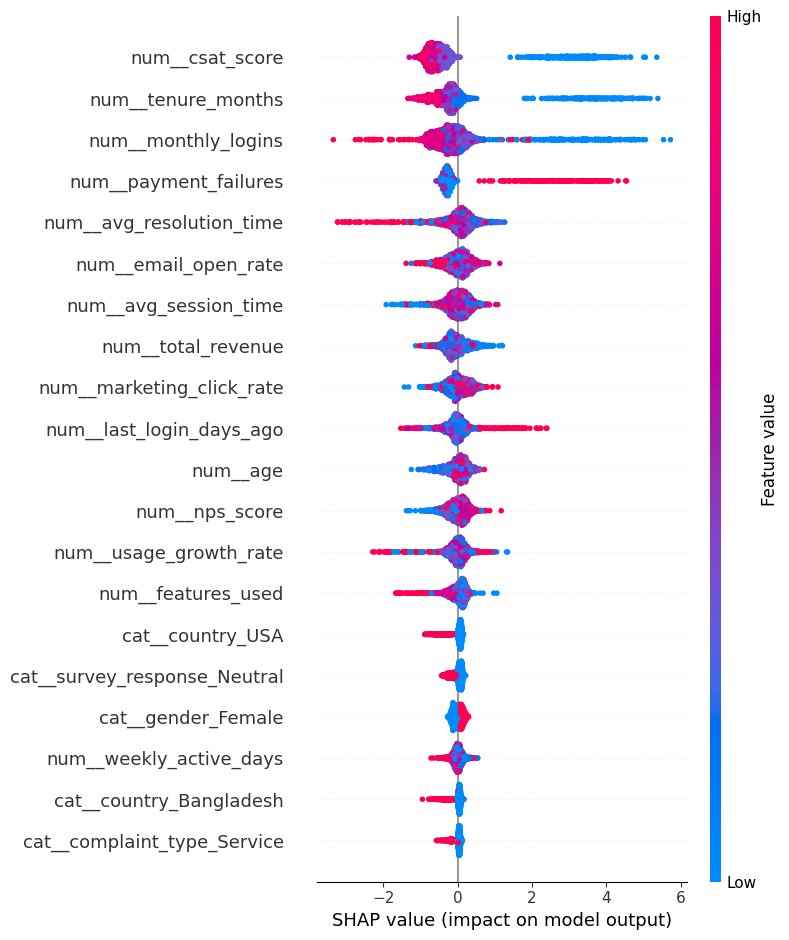

In [31]:
# Create SHAP explainer for tree-based models (LightGBM)
explainer = shap.TreeExplainer(lgbm)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(Xte_df)

# For binary classification, SHAP may return a list [class_0, class_1]
# We use class_1 because it represents "churn"
if isinstance(shap_values, list):
    shap_values_1 = shap_values[1]
    base_value = explainer.expected_value[1]
else:
    shap_values_1 = shap_values
    base_value = explainer.expected_value

# Summary plot shows global feature importance and direction of impact
shap.summary_plot(shap_values_1, Xte_df)

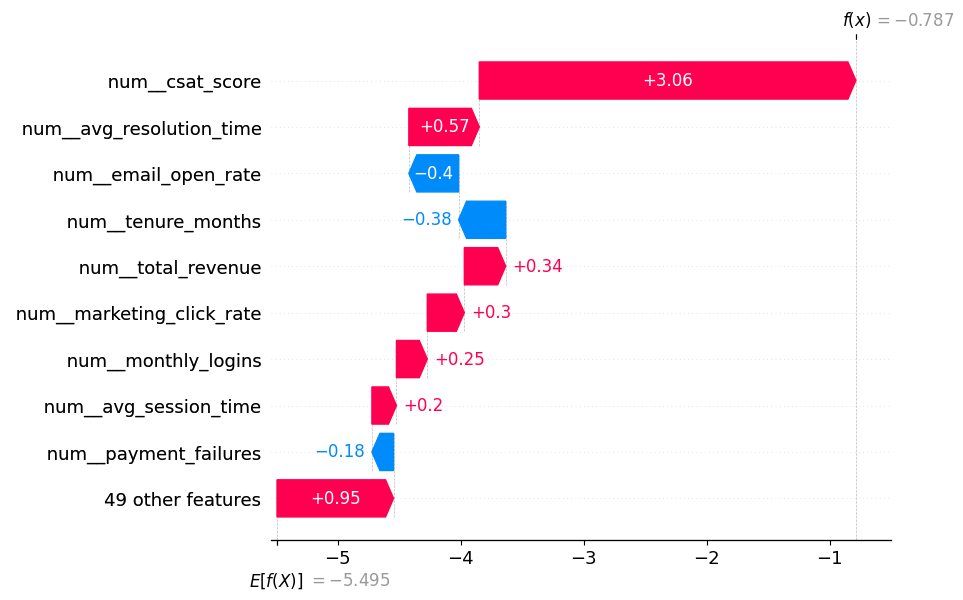

In [32]:
# Select an individual customer to explain
i = 0  # change index to inspect another customer

# Waterfall plot explains how each feature contributes to the churn prediction
shap.plots._waterfall.waterfall_legacy(
    base_value,
    shap_values_1[i],
    Xte_df.iloc[i]
)

Highest-risk customer index: 1988
Churn probability: 0.9864403177788993


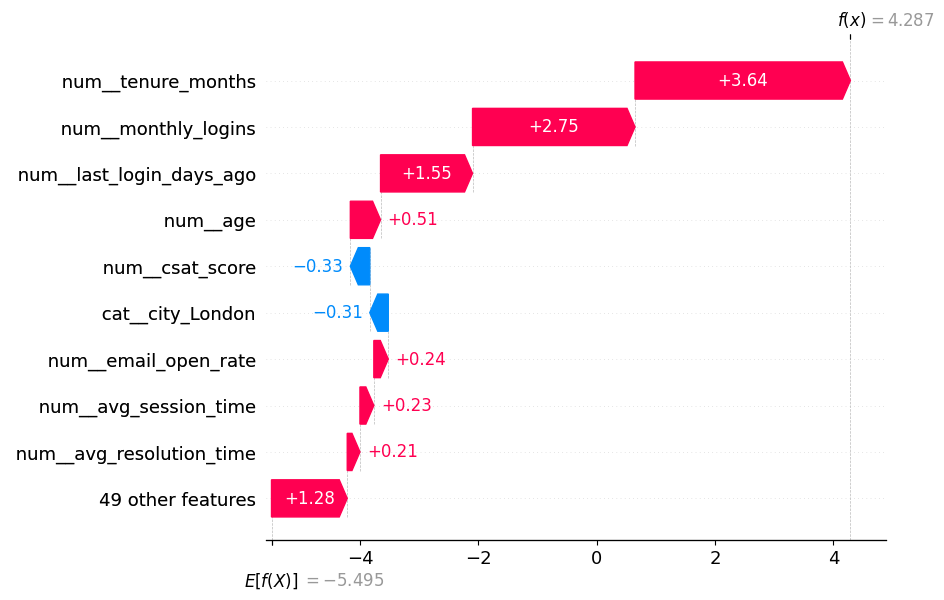

In [33]:
# Get churn probabilities for the test set
proba_test = pipe.predict_proba(X_test)[:, 1]

# Find the index of the customer with the highest churn probability
i = np.argmax(proba_test)

print("Highest-risk customer index:", i)
print("Churn probability:", proba_test[i])

# Explain the prediction for this high-risk customer
shap.plots._waterfall.waterfall_legacy(
    base_value,
    shap_values_1[i],
    Xte_df.iloc[i]
)

In [34]:
# Convert SHAP values for one customer into a Series
impact = pd.Series(shap_values_1[i], index=Xte_df.columns)

# Features that push churn probability higher
top_positive = impact.sort_values(ascending=False).head(15)

# Features that reduce churn probability
top_negative = impact.sort_values(ascending=True).head(15)

# Display top contributing features
display(pd.DataFrame({"Top factors increasing churn risk": top_positive}))
display(pd.DataFrame({"Top factors decreasing churn risk": top_negative}))

,Top factors increasing churn risk
num__tenure_months,3.639424
num__monthly_logins,2.745371
num__last_login_days_ago,1.554341
num__age,0.510502
num__email_open_rate,0.244142
num__avg_session_time,0.234452
num__avg_resolution_time,0.214838
cat__contract_type_Quarterly,0.202394
num__nps_score,0.201953
cat__customer_segment_SME,0.192573


,Top factors decreasing churn risk
num__csat_score,-0.328633
cat__city_London,-0.312565
num__usage_growth_rate,-0.203228
num__payment_failures,-0.182959
cat__contract_type_Yearly,-0.081268
cat__complaint_type_Billing,-0.055896
cat__gender_Female,-0.049525
cat__complaint_type_None,-0.044869
cat__survey_response_Neutral,-0.038038
cat__country_Germany,-0.027237


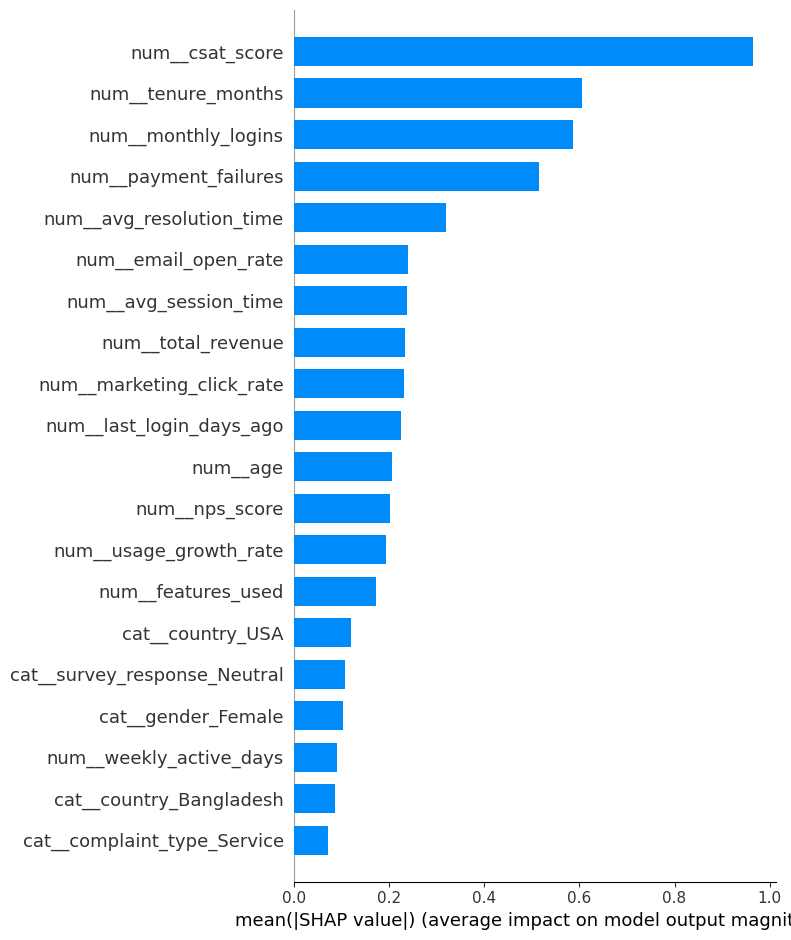

In [35]:
shap.summary_plot(shap_values_1, Xte_df, plot_type="bar")

The bar chart confirms the top global churn drivers and supports the interpretability claim.


In [36]:
# Pick the top features from mean absolute SHAP
mean_abs = np.abs(shap_values_1).mean(axis=0)
top_features = Xte_df.columns[np.argsort(mean_abs)[-5:]][::-1]
top_features

Index(['num__csat_score', 'num__tenure_months', 'num__monthly_logins',
       'num__payment_failures', 'num__avg_resolution_time'],
      dtype='object')

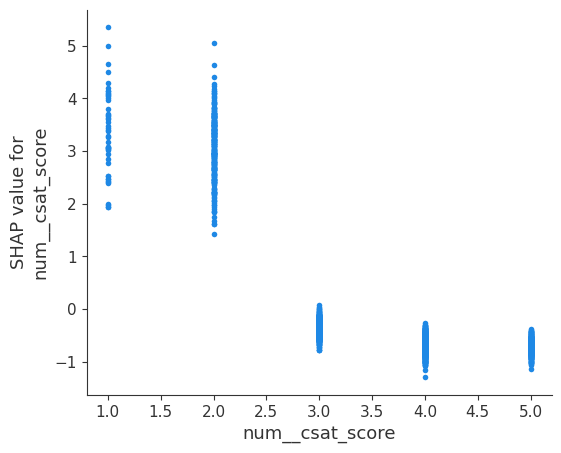

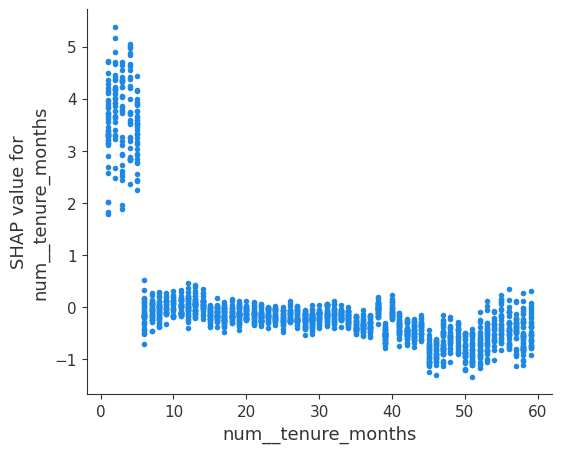

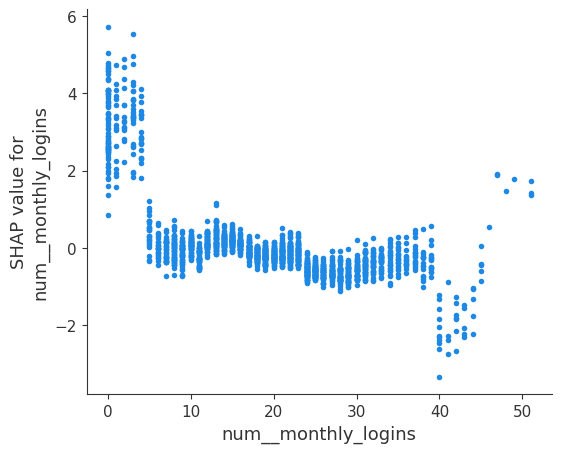

In [38]:
# Dependence plots for top features
for f in top_features[:3]:
    shap.dependence_plot(f, shap_values_1, Xte_df, interaction_index=None)

In [37]:
scored_df.to_csv("churn_scored_customers_FINAL.csv", index=False)
from google.colab import files
files.download("churn_scored_customers_FINAL.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Conclusion

This project demonstrates an end-to-end customer churn prediction system, from data exploration
and feature preprocessing to model training, evaluation, and deployment-oriented scoring.

By combining threshold optimization, cost-aware decision-making, and SHAP-based explainability,
the final solution provides not only accurate predictions but also transparent and actionable
insights for business stakeholders.
